In [1]:
import numpy as np
from skimage import img_as_ubyte
from skimage.io import imread, imsave
from matplotlib import pyplot as plt

In [399]:
def compute_mse(img_1, img_2):
    assert img_1.shape == img_2.shape
    return ((img_1 - img_2) ** 2).sum() / (img_1.shape[0] * img_1.shape[1])


def compute_ncc(img_1, img_2):
    assert img_1.shape == img_2.shape
    return (img_1 * img_2).sum() / np.sqrt((img_1 ** 2).sum() + (img_2 ** 2).sum())


def compute_colored_img(raw_img):
    h = raw_img.shape[0] // 3
    return np.stack((raw_img[2*h:3*h, :], raw_img[h:2*h, :], raw_img[0:h, :])).transpose(1, 2, 0), h


def crop_colored_img(colored_img):
    k = 0.07
    cr = int(k * colored_img.shape[0]), int(k * colored_img.shape[1])
    return colored_img[cr[0]:-cr[0], cr[1]:-cr[1], :]

def align_two(img_1, img_2, shift):
    if shift == (0, 0):
        return img_1, img_2
    if shift[0] == 0:
        if shift[1] > 0:
            return img_1[:, shift[1]:], img_2[:, :-shift[1]]
        else:
            return img_1[:, :shift[1]], img_2[:, -shift[1]:]
    if shift[1] == 0:
        if shift[0] > 0:
            return img_1[shift[0]:, :], img_2[:-shift[0], :]
        else:
            return img_1[:shift[0], :], img_2[-shift[0]:, :]
    
    return align_two(*align_two(img_1, img_2, shift=(shift[0], 0)), shift=(0, shift[1]))

def compute_mse_with_shift(img_1, img_2, shift):
    shifted_1, shifted_2 = align_two(img_1, img_2, shift)
    return compute_mse(shifted_1, shifted_2)

def compute_ncc_with_shift(img_1, img_2, shift):
    shifted_1, shifted_2 = align_two(img_1, img_2, shift)
    return compute_ncc(shifted_1, shifted_2)

In [321]:
img = img_as_ubyte(imread(f'public_tests/{0}{1}_test_img_input/img.png'))

print(img.shape)
colored_img, h = compute_colored_img(img)
print(colored_img.shape)
print(h)
print(0, h, ' ', h, 2 * h, ' ', 2 * h, 3 * h, ' ')
cropped_img = crop_colored_img(colored_img)
print(cropped_img.shape)


(1024, 398)
(341, 398, 3)
341
0 341   341 682   682 1023  
(295, 344, 3)


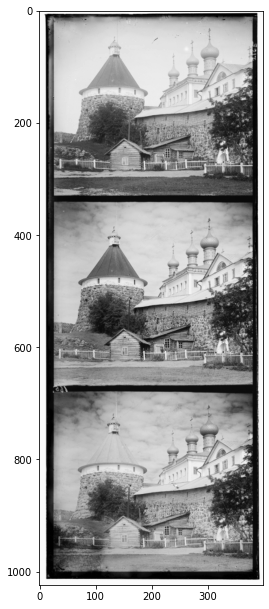

In [323]:
plt.figure(figsize=(4, 12))
plt.imshow(img, cmap='gray')

In [ ]:
plt.figure(figsize=(21, 14))

for i in range(3):
    plt.subplot(2, 3, i + 1)
    plt.imshow(colored_img[:, :, i], cmap='gray')
    
for i in range(3):
    plt.subplot(2, 3, 3 + i + 1)
    plt.imshow(cropped_img[:, :, i], cmap='gray')

In [390]:
shift_range = 15
xv, yv = np.meshgrid(np.arange(-shift_range, shift_range), np.arange(-shift_range, shift_range))
shifts = np.stack((xv.ravel(), yv.ravel())).T

In [404]:
mses_r = np.array([compute_mse_with_shift(cropped_img[:, :, 1], cropped_img[:, :, 0], tuple(shift)) for shift in shifts])
best_r_shift = shifts[mses_r.argmin()]
best_r_shift

array([-5, -7])

In [405]:
mses_b = np.array([compute_mse_with_shift(cropped_img[:, :, 1], cropped_img[:, :, 2], tuple(shift)) for shift in shifts])
best_b_shift = shifts[mses_b.argmin()]
best_b_shift

array([-2, -1])

In [406]:
mses_r = np.array([compute_ncc_with_shift(cropped_img[:, :, 1], cropped_img[:, :, 0], tuple(shift)) for shift in shifts])
best_r_shift = shifts[mses_r.argmax()]
best_r_shift

array([ 0, -1])

In [407]:
mses_b = np.array([compute_ncc_with_shift(cropped_img[:, :, 1], cropped_img[:, :, 2], tuple(shift)) for shift in shifts])
best_b_shift = shifts[mses_b.argmax()]
best_b_shift

array([0, 1])

In [393]:
def g_to_b(row, col):
    return row - h + best_b_shift[0], col + best_b_shift[1]
def g_to_r(row, col):
    return row + h + best_r_shift[0], col + best_r_shift[1]


g_to_b(386,134,), g_to_r(386,134)

((43, 133), (722, 127))

In [403]:
def align(img, g_coord):
    img = (img * 255).astype('uint8')
    
    colored_img, h = compute_colored_img(img)
    cropped_img = crop_colored_img(colored_img)
    
    shift_range = 15
    xv, yv = np.meshgrid(np.arange(-shift_range, shift_range), np.arange(-shift_range, shift_range))
    shifts = np.stack((xv.ravel(), yv.ravel())).T
    
    mses_r = np.array([compute_ncc_with_shift(cropped_img[:, :, 1], cropped_img[:, :, 0], tuple(shift)) for shift in shifts])
    best_r_shift = shifts[mses_r.argmax()]
    
    mses_b = np.array([compute_ncc_with_shift(cropped_img[:, :, 1], cropped_img[:, :, 2], tuple(shift)) for shift in shifts])
    best_b_shift = shifts[mses_b.argmax()]
    
    res_img = colored_by_shift(cropped_img[:, :, 1], cropped_img[:, :, 2], cropped_img[:, :, 0], best_b_shift, best_r_shift)
    
    return res_img, (g_coord[0] - h + best_b_shift[0], g_coord[1] + best_b_shift[1]), (
        g_coord[0] + h + best_r_shift[0], g_coord[1] + best_r_shift[1])

In [401]:
def colored_by_shift(g, b, r, bs, rs):
    return np.stack((np.roll(r, rs, axis=(0, 1)), g, np.roll(b, bs, axis=(0, 1)))).transpose((1, 2, 0))

In [402]:
res_img = colored_by_shift(cropped_img[:, :, 1], cropped_img[:, :, 2], cropped_img[:, :, 0], best_b_shift, best_r_shift)
res_img.shape

(295, 344, 3)

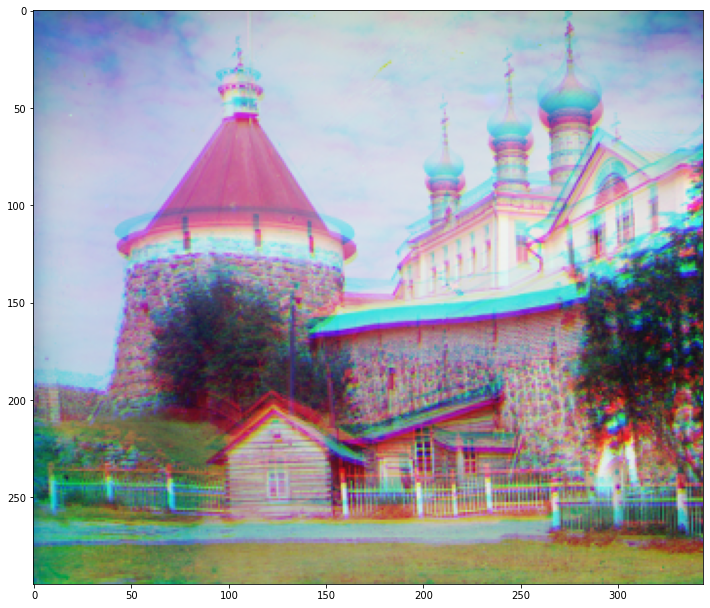

In [397]:
plt.figure(figsize=(12, 12))
plt.imshow(cropped_img, cmap='gray')

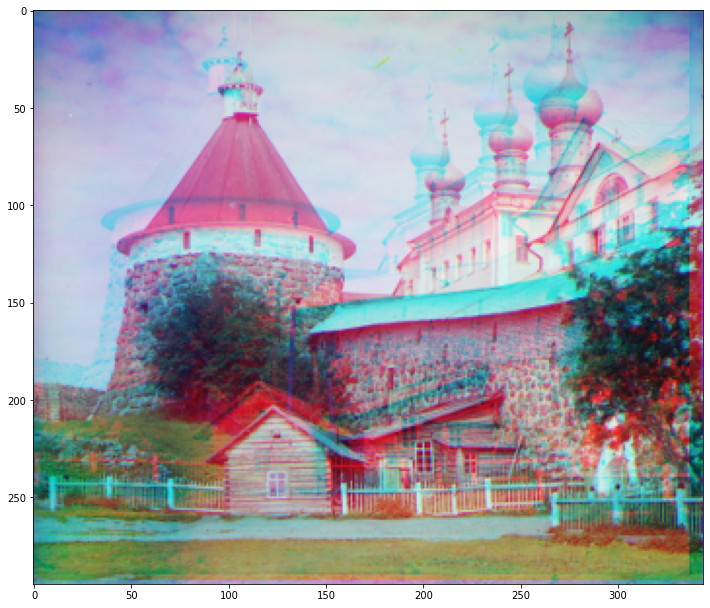

In [398]:
plt.figure(figsize=(12, 12))
plt.imshow(res_img, cmap='gray')

In [ ]:
np.roll

In [207]:
t = np.stack((np.ones((8,7)), np.zeros((8,7)))).transpose(1,2,0)

In [211]:
t = np.arange(30).reshape((6,5))

In [215]:
np.roll(t, 1, 1)

array([[ 4,  0,  1,  2,  3],
       [ 9,  5,  6,  7,  8],
       [14, 10, 11, 12, 13],
       [19, 15, 16, 17, 18],
       [24, 20, 21, 22, 23],
       [29, 25, 26, 27, 28]])